In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import ttest_ind
import seaborn as sns

from src.config import DADOS_ORIGINAIS, DADOS_TRATADOS
from src.graficos import plot_correl_matrix

sns.set_theme(palette='bright')

In [2]:
# Importação da base de dados
data = DADOS_ORIGINAIS

df = pd.read_csv(data)
df.head(3)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [3]:
# Reordenação das colunas
df = df.reindex([col for col in sorted(df.columns) if col != 'diagnosis'] + ['diagnosis'], axis=1)

# Padronizando nome da variável alvo
df.rename(columns={'diagnosis': 'target'}, inplace=True)

# Informações da base de dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   area_mean                569 non-null    float64
 1   area_se                  569 non-null    float64
 2   area_worst               569 non-null    float64
 3   compactness_mean         569 non-null    float64
 4   compactness_se           569 non-null    float64
 5   compactness_worst        569 non-null    float64
 6   concave points_mean      569 non-null    float64
 7   concave points_se        569 non-null    float64
 8   concave points_worst     569 non-null    float64
 9   concavity_mean           569 non-null    float64
 10  concavity_se             569 non-null    float64
 11  concavity_worst          569 non-null    float64
 12  fractal_dimension_mean   569 non-null    float64
 13  fractal_dimension_se     569 non-null    float64
 14  fractal_dimension_worst  5

In [4]:
# Remoção da coluna 'id'
df = df.drop(columns=['id'])

# Definição da variável target
target = 'target'

# Seleção das colunas numéricas
col_num = df.drop(columns=[target]).columns

# Downcast das colunas float
df[col_num] = df[col_num].apply(pd.to_numeric, downcast='float')

# Conversão da colunas target em categórica
df[target] = df[target].astype('category')

# Resultado
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   area_mean                569 non-null    float32 
 1   area_se                  569 non-null    float32 
 2   area_worst               569 non-null    float32 
 3   compactness_mean         569 non-null    float32 
 4   compactness_se           569 non-null    float32 
 5   compactness_worst        569 non-null    float32 
 6   concave points_mean      569 non-null    float32 
 7   concave points_se        569 non-null    float32 
 8   concave points_worst     569 non-null    float32 
 9   concavity_mean           569 non-null    float32 
 10  concavity_se             569 non-null    float32 
 11  concavity_worst          569 non-null    float32 
 12  fractal_dimension_mean   569 non-null    float32 
 13  fractal_dimension_se     569 non-null    float32 
 14  fractal_di

### Análise estatística descritiva das variáveis

#### Variáveis preditoras

A partir do describe realizado na base de dados, alguns pontos observados incluem:

- Diferença significativa na escala dos dados para diferentes variáveis.
- Grande amplitude, com valores máximos distantes da mediana, sugerindo presença de outliers.

Sugestões a serem avaliadas no treinamento do modelo incluem:

- Normalização das variáveis a fim de suavizar escala.

#### Variáveis alvo

Outro ponto observado foi o desbalanceamento aparente entre as duas classes possíveis:

| Classe    | Proporção |
|-----------|-----------|
| Benigno   | 62.74%    |
| Maligno   | 37.26%    |

Sugestões a serem avaliadas no treinamento do modelo incluem:

- Estratificação da base no momento do treinamento, a fim de diminuir os impactos do desbalanceamento.

In [5]:
# Descrição estatística das variáveis
df.describe().round(4)

,area_mean,area_se,area_worst,compactness_mean,compactness_se,compactness_worst,concave points_mean,concave points_se,concave points_worst,concavity_mean,...,radius_worst,smoothness_mean,smoothness_se,smoothness_worst,symmetry_mean,symmetry_se,symmetry_worst,texture_mean,texture_se,texture_worst
count,569.0000,569.0000,569.0000,569.0000,569.0000,569.0000,569.0000,569.0000,569.0000,569.0000,...,569.0000,569.0000,569.0000,569.0000,569.0000,569.0000,569.0000,569.0000,569.0000,569.0000
mean,654.8890,40.3371,880.5831,0.1043,0.0255,0.2543,0.0489,0.0118,0.1146,0.0888,...,16.2692,0.0964,0.0070,0.1324,0.1812,0.0205,0.2901,19.2896,1.2169,25.6772
std,351.9141,45.4910,569.3569,0.0528,0.0179,0.1573,0.0388,0.0062,0.0657,0.0797,...,4.8332,0.0141,0.0030,0.0228,0.0274,0.0083,0.0619,4.3010,0.5516,6.1463
min,143.5000,6.8020,185.2000,0.0194,0.0023,0.0273,0.0000,0.0000,0.0000,0.0000,...,7.9300,0.0526,0.0017,0.0712,0.1060,0.0079,0.1565,9.7100,0.3602,12.0200
25%,420.3000,17.8500,515.3000,0.0649,0.0131,0.1472,0.0203,0.0076,0.0649,0.0296,...,13.0100,0.0864,0.0052,0.1166,0.1619,0.0152,0.2504,16.1700,0.8339,21.0800
50%,551.1000,24.5300,686.5000,0.0926,0.0204,0.2119,0.0335,0.0109,0.0999,0.0615,...,14.9700,0.0959,0.0064,0.1313,0.1792,0.0187,0.2822,18.8400,1.1080,25.4100
75%,782.7000,45.1900,1084.0000,0.1304,0.0325,0.3391,0.0740,0.0147,0.1614,0.1307,...,18.7900,0.1053,0.0081,0.1460,0.1957,0.0235,0.3179,21.8000,1.4740,29.7200
max,2501.0000,542.2000,4254.0000,0.3454,0.1354,1.0580,0.2012,0.0528,0.2910,0.4268,...,36.0400,0.1634,0.0311,0.2226,0.3040,0.0790,0.6638,39.2800,4.8850,49.5400


In [6]:
# Balanceamento entre classes do target
df[target].value_counts(normalize=True)

target
B    0.627417
M    0.372583
Name: proportion, dtype: float64

### Análise estatística gráfica das variáveis

#### Impressões iniciais

A partir dos histogramas e boxplots construídos, podemos observar:

- Formato da distribuição por variável por classe.
- Presença de outliers em algumas variáveis.
- Sobreposição entre as distribuições/boxplots das duas classes para a mesma variável.

#### Variáveis aparentemente insiginificantes
Devido a alta sobreposição, algumas colunas chamam atenção para provável descarte por indicarem insignicância estatística, que será confirmado posteriormente a partir de outros testes. As colunas destacadas incluem::

- `compacteness_se`
- `concavity_se`
- `fractal_dimension_mean`
- `fractal_dimension_se`
- `smoothness_se`
- `symmetry_se`
- `texture_se`

#### Análise de correlação

A partir da matriz de correlação é possível observar, através da camada de foco aplicada (>= 0.70), variáveis altamente correlacionadas entre si. Esse fato pode indicar multicolinearidade e, portanto, a necessidade de aplicar regularizações no momento de treinamento do modelo.

Além disso, algumas variáveis se destacam por possuírem, em primeira análise, alta correlação com o target (>= 0.70), indicando serem boas preditoras. São elas:

- `concave points_worst`
- `perimeter_worst`
- `concavepoints_mean`
- `radius_worst`
- `perimeter_mean`
- `area_worst`
- `radius_mean`
- `area_mean`

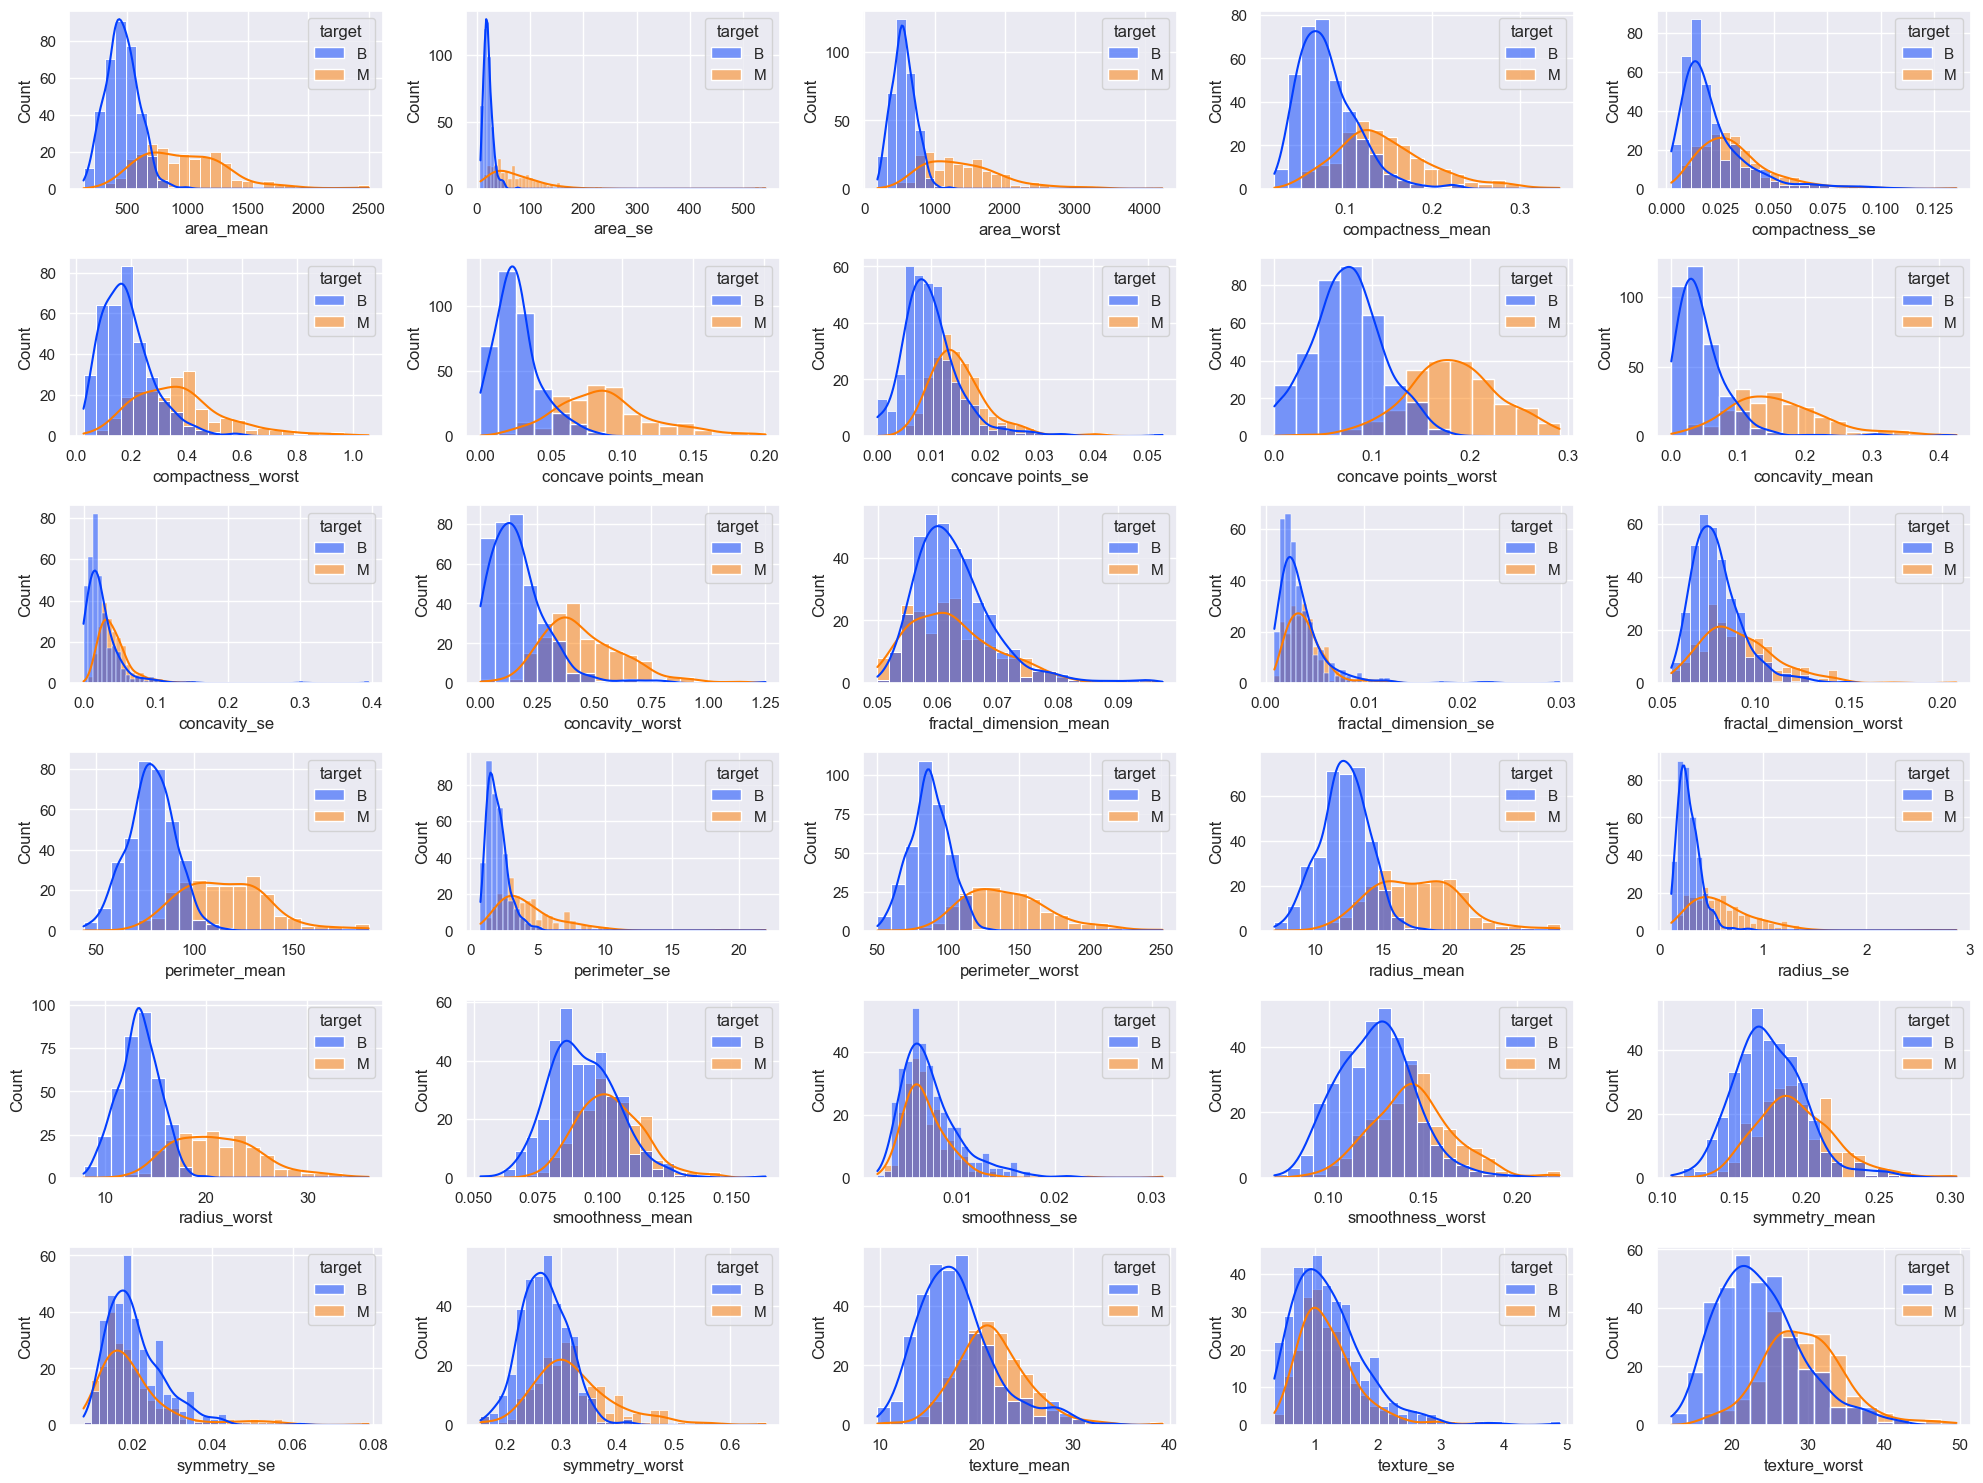

In [7]:
# Visualização da distribuição das variáveis
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(20, 15))
axes = axes.flatten()

for i, col in enumerate(df[col_num]):
    sns.histplot(data=df, x=col, ax=axes[i], kde=True, hue=target)


plt.tight_layout()
plt.show()

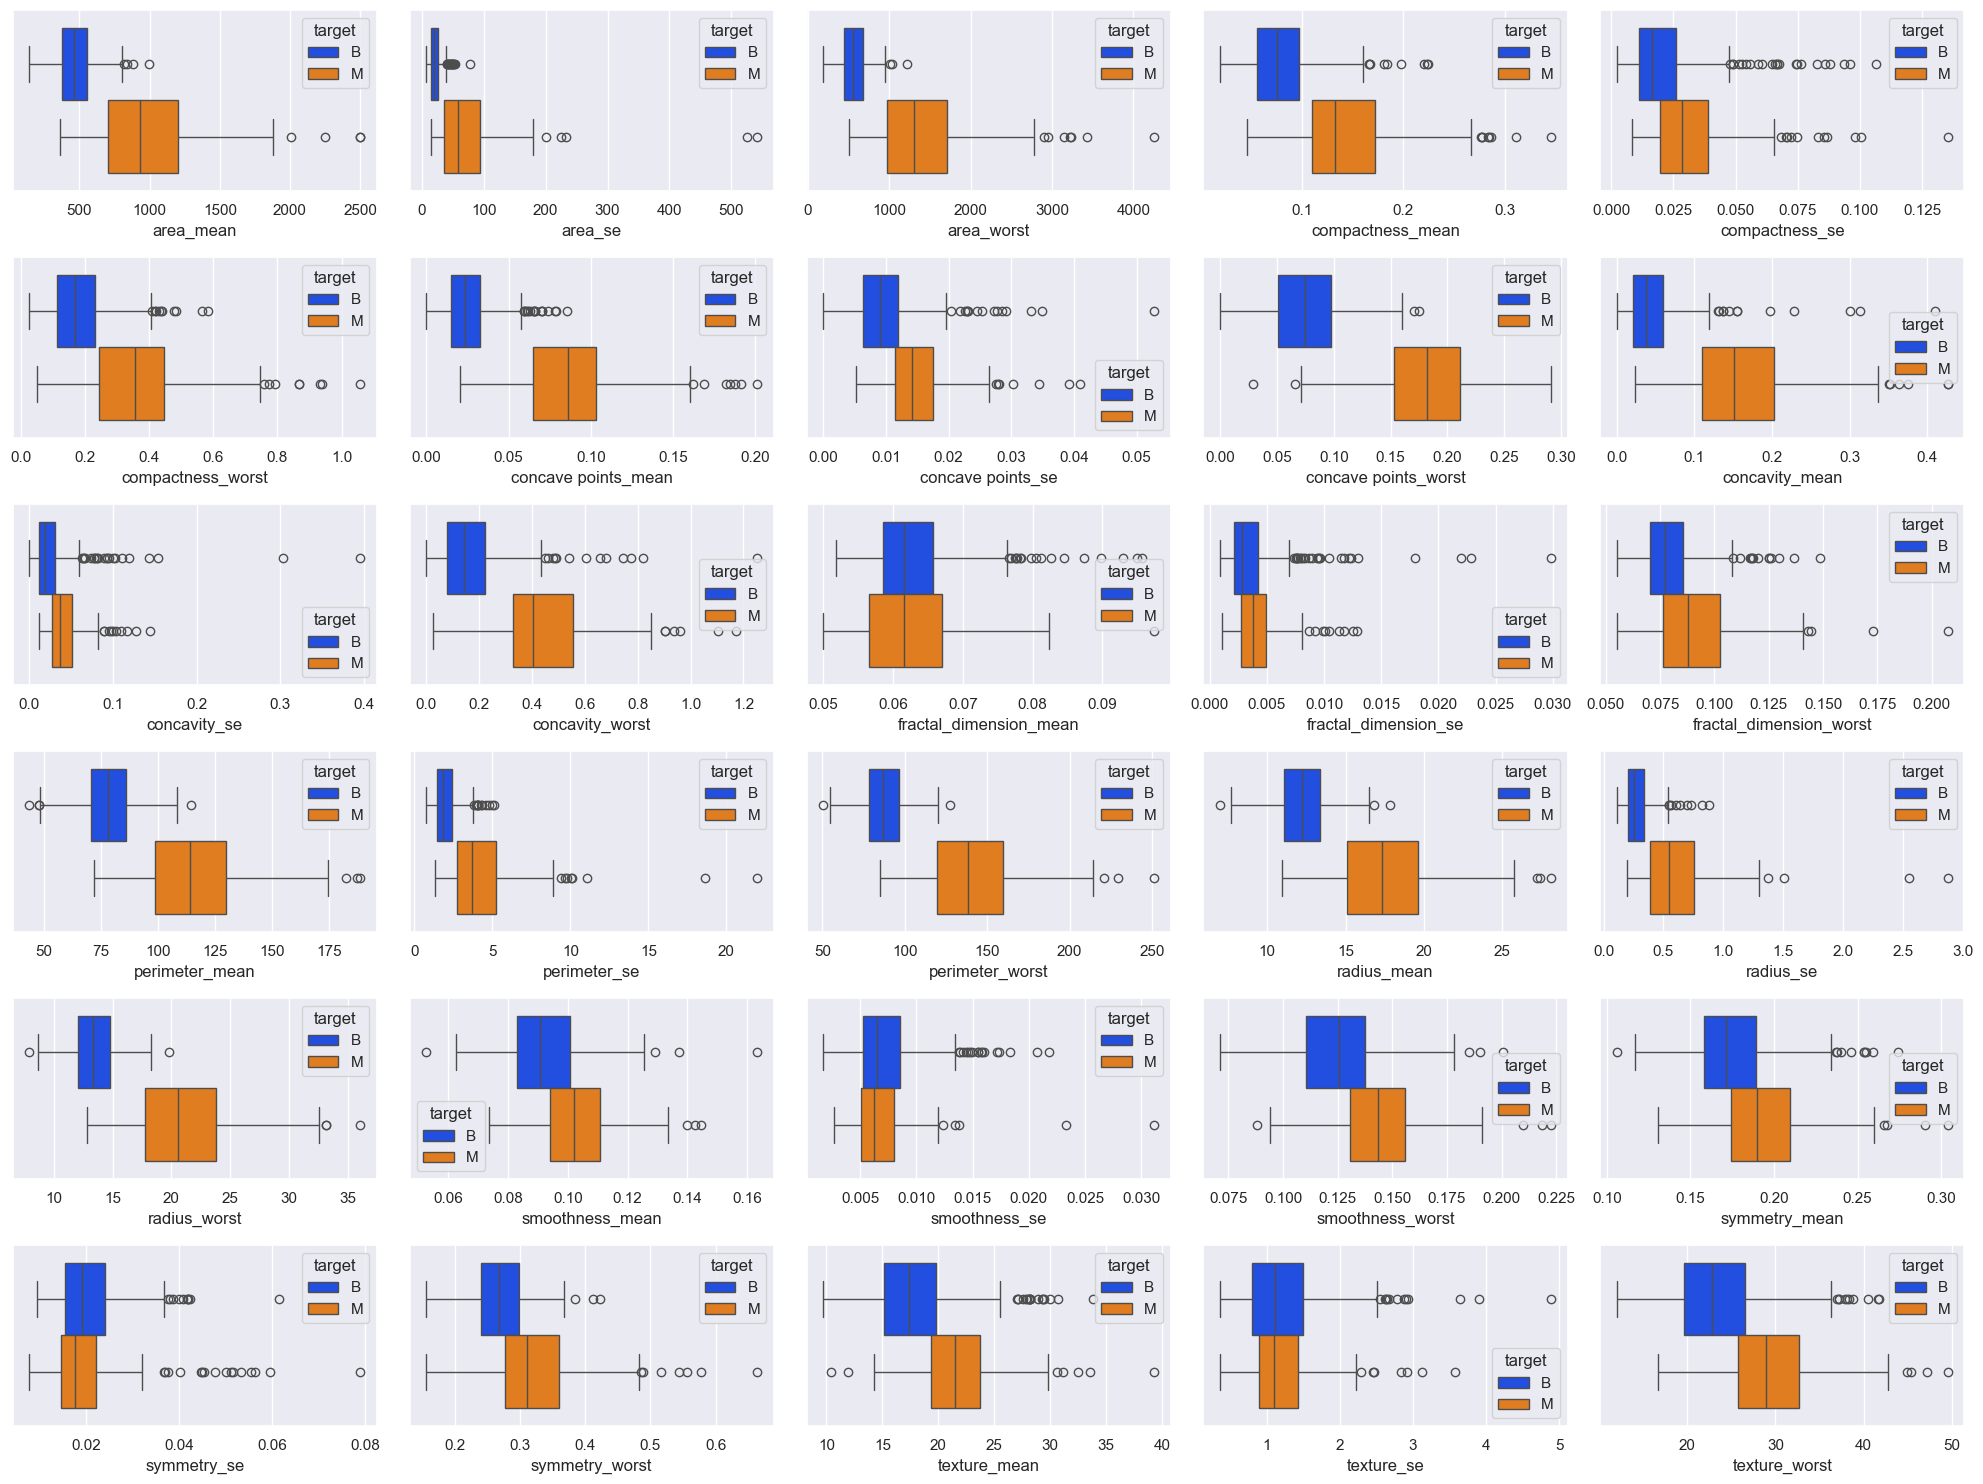

In [8]:
# Visualização da distribuição das variáveis
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(20, 15))
axes = axes.flatten()

for i, col in enumerate(df[col_num]):
    sns.boxplot(data=df, x=col, ax=axes[i], hue=target)


plt.tight_layout()
plt.show()

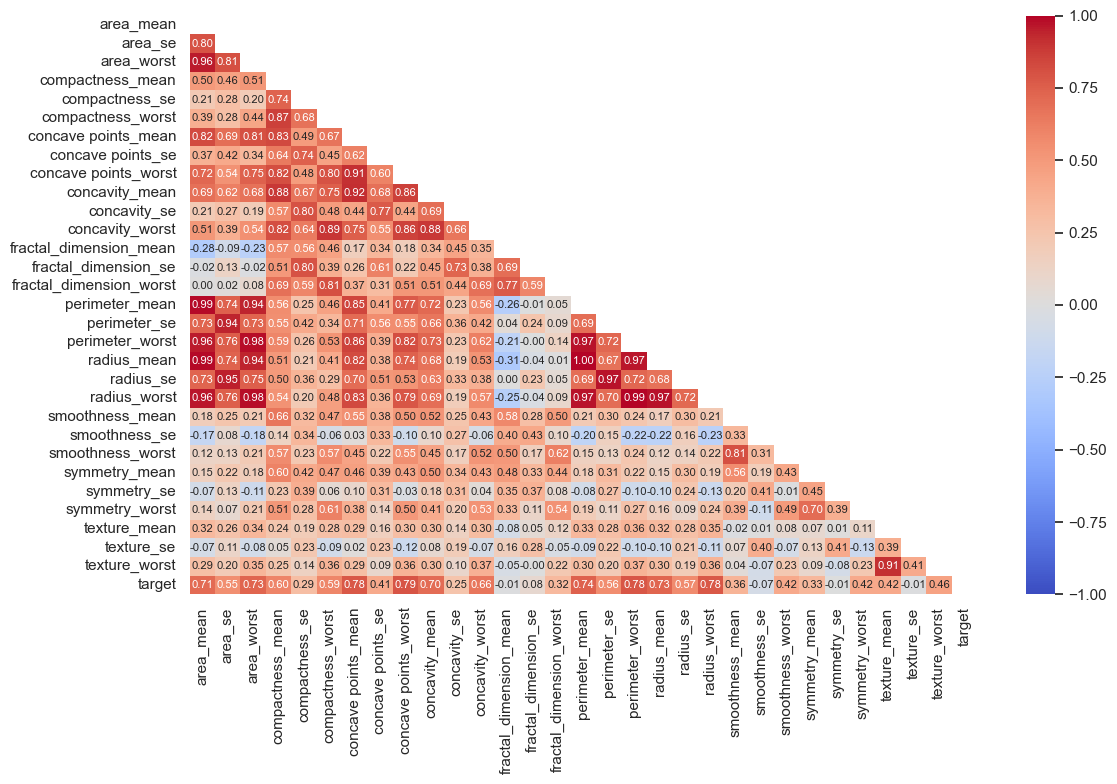

In [9]:
# Matriz de correlação de pearson
df_correl = df.copy()
df_correl['target'] = df_correl['target'].map({'B': 0, 'M': 1}).astype('int')
plot_correl_matrix(df_correl, figsize=(12, 8))

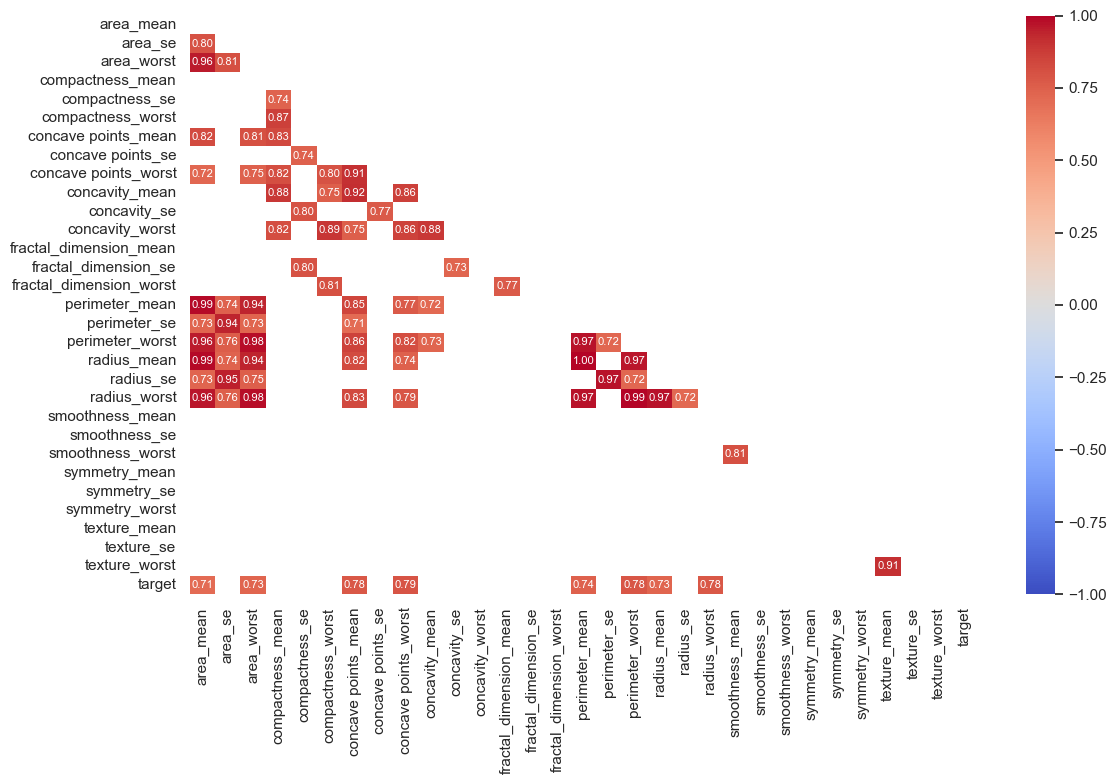

In [10]:
# Features com |correlação| >= 0.7
plot_correl_matrix(df_correl, figsize=(12, 8), focus=0.7)

In [11]:
# Variáveis de correlação com o target >= 0.7
correl = df_correl.corr()['target']
correl = correl[abs(correl) >= 0.7].sort_values(ascending=False)
correl

target                  1.000000
concave points_worst    0.793566
perimeter_worst         0.782914
concave points_mean     0.776614
radius_worst            0.776454
perimeter_mean          0.742636
area_worst              0.733825
radius_mean             0.730029
area_mean               0.708984
Name: target, dtype: float64

### Remoção de colunas indesejadas

#### Teste T de significância

A fim de remover colunas indesejadas, foi realizado o teste T de significância para confirmar as hipóteses levantadas previamente. Para isso, foi estabelecido um alfa de 0.05.

Após resultados, 5 colunas demonstraram serem insignificantes quanto a sua capacidade de distinguir entre as diferentes classes e foram, portanto, removidas. São elas:

- `fractal_dimension_mean`
- `fractal_dimension_se`
- `smoothness_se`
- `symmetry_se`
- `texture_se`

In [12]:
# Teste T de significância estatística das features
ttest_results = {}

# Classes do target
classes = df[target].unique().tolist()

# Nível de significância
alfa = 0.05

# Cálculo da estatística T
for col in col_num:
    grupo1 = df[df[target] == classes[0]][col]
    grupo2 = df[df[target] == classes[1]][col]
    
    estatistica_t, pvalue = ttest_ind(grupo1, grupo2)
    
    ttest_results[col] = {
        "p-valor": pvalue,
        "estatistica t": estatistica_t,
        "significancia": pvalue < alfa
    }

ttest_results = pd.DataFrame(ttest_results).T
ttest_results

,p-valor,estatistica t,significancia
area_mean,0.0,23.938688,True
area_se,0.0,15.609342,True
area_worst,0.0,25.72159,True
compactness_mean,0.0,17.698396,True
compactness_se,0.0,7.297077,True
compactness_worst,0.0,17.445374,True
concave points_mean,0.0,29.354314,True
concave points_se,0.0,10.642499,True
concave points_worst,0.0,31.054551,True
concavity_mean,0.0,23.103965,True


In [13]:
# Visualização das variáveis estatísticamente insignificantes
df_insignificantes = ttest_results.query('significancia == False')
df_insignificantes

,p-valor,estatistica t,significancia
fractal_dimension_mean,0.759928,-0.305723,False
fractal_dimension_se,0.063073,1.862331,False
smoothness_se,0.110297,-1.599363,False
symmetry_se,0.876645,-0.155294,False
texture_se,0.843333,-0.197723,False


In [14]:
# Remoção das colunas estatisticamente insignificantes
df = df.drop(columns=df_insignificantes.index)

In [15]:
# Salvamento dos dados tratados
df.to_csv(DADOS_TRATADOS, index=False)